# Deep Fashion 2 dataset generation

In [1]:
import os
import json
import itertools

import skimage.io

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from shutil import copyfile

from sklearn.model_selection import train_test_split

from data_loader import load_training_df
from masks import get_mask

In [10]:
dataset_path = '../data/fs2'
output_dir = '../data/deep_fashion_segmentation_dataset'
toy_output_dir = '../data/deep_fashion_segmentation_dataset_toy'

# Generate dataset

## Read data

Read images and annotations in training.

In [5]:
df = load_training_df(dataset_path)

Show samples.

In [ ]:
df.sample(3)

Drop non-relevant columns. Note that we decide to use **both shop and user images**.

In [6]:
# Drop landmarks as we already have segmentation masks
df = df.drop(columns=['scale', 'viewpoint', 'zoom_in', 'landmarks', 'bounding_box', 'occlusion', 'style',  'pair_id', 'source'])

## Redefine categories

Coarse categorization

- Top:  `short sleeve top`, `long sleeve top`, `sling` and `vest`.
- Outwear: `short sleeve outwear` and `long sleeve outwear`.
- Skirt (`skirt`).
- Trousers (`trousers`).
- Shorts (`shorts`).
- Dress. Contains `vest dress`, `short sleeve dress` and`sling dress`.

Map categories to supercategory.

In [7]:
supercategory_map = {
    'short sleeve top': 'top',
    'long sleeve dress': 'dress',
    'trousers': 'trousers',
    'long sleeve top': 'top',
    'skirt': 'skirt',
    'shorts': 'shorts',
    'long sleeve outwear': 'outwear',
    'vest dress': 'dress',
    'short sleeve dress': 'dress',
    'vest': 'top',
    'sling dress': 'dress',
    'short sleeve outwear': 'outwear',
    'sling': 'top'
}

# Map category to supercategory
df.loc[:, 'supercategory_name'] = df['category_name'].map(supercategory_map)

# Create id for supercategories
# Make sure ids start at 1
supercategory_id_map = {
    name: i + 1
    for i, name in enumerate(set(supercategory_map.values()))
}
df['supercategory_id'] = df['supercategory_name'].map(supercategory_id_map)

# Ensure no extra categories exist
assert set(supercategory_map.values()) == set(df['supercategory_name'].unique())

Visualize now the distribution of clothing supercategories.

<AxesSubplot:>

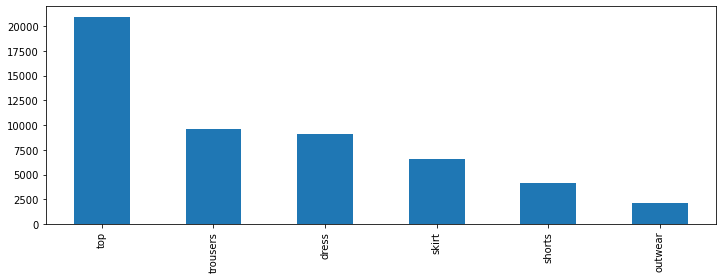

In [8]:
df['supercategory_name'].value_counts().plot.bar(figsize=(12, 4))

## Group clothes per image

In [9]:
def _join_all_rows(df: pd.DataFrame) -> pd.Series:
    result = {col: df[col].values for col in df.columns.values}
    # Make sure we keep the id
    result.update({'id': df.name})
    return result

images_series = df.groupby('id').apply(_join_all_rows)
images_df = pd.DataFrame.from_records(images_series.values)
print(f'Using {len(images_df)} images')

Using 32153 images


## Store dataset

In [11]:
os.makedirs(output_dir, exist_ok=True)

Prepare output directories.

In [12]:
image_dir = 'images'
mask_dir = 'masks'

os.makedirs(os.path.join(output_dir, 'images'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'masks'), exist_ok=True)

Generate path to images and masks in the Dataframe.

In [13]:
def build_mask_png_path(files: str) -> str:
    basename = os.path.basename(files[0])
    filename = os.path.splitext(basename)[0]
    return os.path.join(mask_dir, filename + '.png')


images_df['source_path'] = images_df['image_path'].apply(
    lambda files: os.path.join(image_dir, os.path.basename(files[0]))
)

images_df.loc[:, 'mask_path'] = images_df['image_path'].apply(build_mask_png_path)

Store picture and mask images for each row.

In [14]:
n_labels = len(supercategory_id_map)

def get_mask_image(row: pd.Series) -> np.ndarray:
    
    n_objects = len(row['segmentation'])
    image = skimage.io.imread(row['image_path'][0])
    image_height, image_width = image.shape[:2]
    
    # Build mask matrix
    mask = np.zeros((image_height, image_width), dtype=np.uint8)
    
    # IMPORTANT: order of clothes matter in the resulting mask as
    # masks do overlap
    for i in range(n_objects):
        submask = get_mask(image_height,
                           image_width,
                           row['segmentation'][i],
                           category_id=int(row['supercategory_id'][i]))
        mask = np.where(submask != 0, submask, mask)

    return mask


def store_example(row: pd.Series, folder: str) -> bool:
     
    try:
        # Copy image
        image_dst_path = os.path.join(folder, row['source_path'])
        copyfile(row['image_path'][0], image_dst_path)
        # Generate and store mask
        mask_dst_path = os.path.join(folder, row['mask_path'])
        skimage.io.imsave(mask_dst_path, get_mask_image(row))
        return True
    except Exception as e:
        print(f'Could not store example: {str(e)}')
        return False

# # Ignore warnings generated when storing mask images
import warnings
warnings.filterwarnings('ignore')
images_df['created_ok'] = images_df.apply(
    lambda x: store_example(x, output_dir), axis=1
)

## Generate clean CSV

Now let's only keep the path to the image and the mask as well as the mapping between supercategories and their ids.

Let's remove the rows that raised errors.

In [15]:
dataset_df = images_df[images_df['created_ok']==True]
print(f'{len(images_df) - len(dataset_df)} images could not be stored')

0 images could not be stored


In [16]:
dataset_df = dataset_df[['mask_path', 'source_path', 'supercategory_id']]

In [17]:
dataset_df = dataset_df.rename(columns={'source_path': 'image_path',
                                        'supercategory_id': 'labels'})

In [18]:
dataset_df

,mask_path,image_path,labels
0,masks\000001.png,images\000001.jpg,"[1, 5]"
1,masks\000002.png,images\000002.jpg,"[1, 5]"
2,masks\000003.png,images\000003.jpg,[1]
3,masks\000004.png,images\000004.jpg,[1]
4,masks\000005.png,images\000005.jpg,[5]
...,...,...,...
32148,masks\032149.png,images\032149.jpg,[1]
32149,masks\032150.png,images\032150.jpg,[1]
32150,masks\032151.png,images\032151.jpg,[1]
32151,masks\032152.png,images\032152.jpg,[1]


Perform training-validation-test split.

In [19]:
def _row_to_set(row: pd.Series) -> str:
    if row.name in train_idx:
        return 'train'
    elif row.name in val_idx:
        return 'validation'
    elif row.name in test_idx:
        return 'test'
    else:
        raise ValueError(f'Unknown row index: {row.name}')

train_idx, test_idx = train_test_split(dataset_df.index, test_size=0.025, random_state=500)
train_idx, val_idx = train_test_split(train_idx, test_size=0.0125, random_state=300)

dataset_df['set'] = dataset_df.apply(_row_to_set, axis=1)

Visualize instances per set.

In [20]:
dataset_df['set'].value_counts()

train         30957
test            804
validation      392
Name: set, dtype: int64

Store DataFrame as json.

In [21]:
dataset_df.to_json(os.path.join(output_dir, 'data.json'), orient='records')

## Store supercategory id mapping

In [23]:
inverse_supercategory_id_map = {
    category_id: category_name
    for category_name, category_id in supercategory_id_map.items()
}

labels_path = os.path.join(output_dir, 'labels.json')
with open(labels_path, 'w') as file:
    json.dump(inverse_supercategory_id_map, file)

## Copy README into dataset

In [24]:
copyfile('dataset_README.md', os.path.join(output_dir, 'README.md'));

## Visualize Dataset

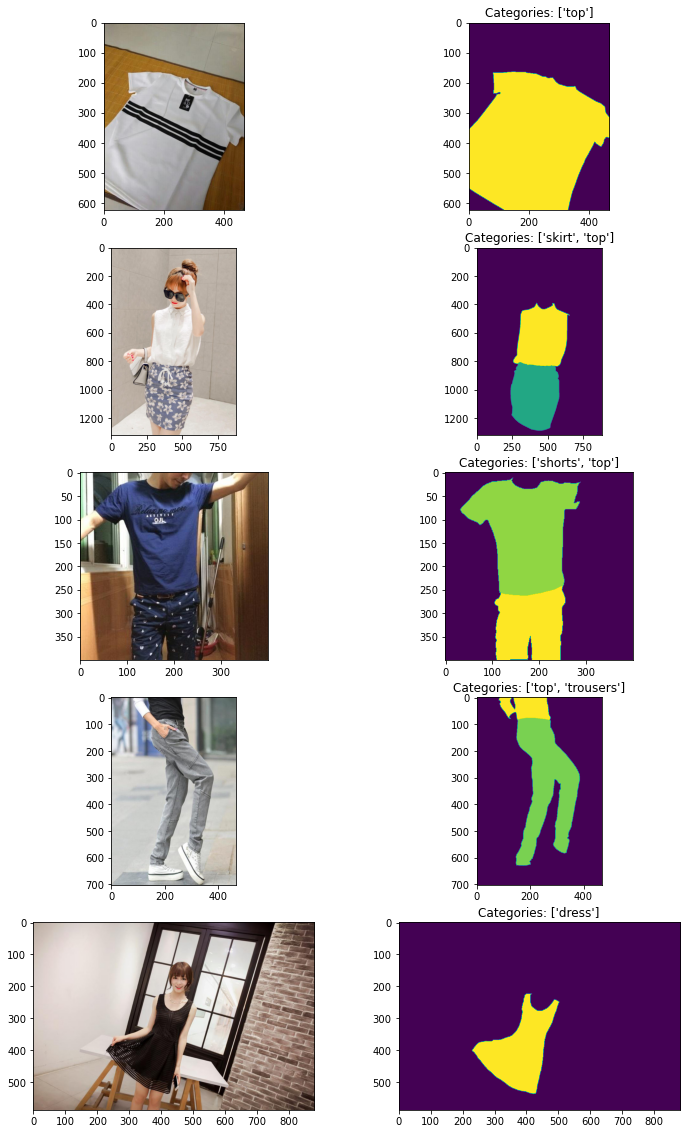

In [25]:
n_rows = 5
fig, axs = plt.subplots(n_rows, 2, figsize=(12, n_rows*4.0))

for i in range(n_rows):

    sample = dataset_df.sample(1).iloc[0]

    # Parse image and mask
    image = skimage.io.imread(os.path.join(output_dir, sample['image_path']))
    mask = skimage.io.imread(os.path.join(output_dir, sample['mask_path']))
    labels = sample['labels']
    # Parse labels
    str_labels = [inverse_supercategory_id_map[category_id] for category_id in labels]

    axs[i][0].imshow(image)
    axs[i][1].set_title(f'Categories: {str_labels}')
    axs[i][1].imshow(mask)

## Extract some stats

In [26]:
def _category_count(df: pd.DataFrame) -> dict:
    label_ids = df['labels'].apply(lambda x: x.tolist()).values
    label_ids = list(itertools.chain.from_iterable(label_ids))
    label_ids_count = np.unique(label_ids, return_counts=True)
    return {
        inverse_supercategory_id_map[label_id]: label_count
        for label_id, label_count in zip(*label_ids_count)
    }

print(f'All instances category count: {_category_count(dataset_df)}')
print(f'Training set category count: {_category_count(dataset_df[dataset_df["set"] == "train"])}')
print(f'Validation set category count: {_category_count(dataset_df[dataset_df["set"] == "validation"])}')
print(f'Test set category count: {_category_count(dataset_df[dataset_df["set"] == "test"])}')

All instances category count: {'dress': 9105, 'outwear': 2153, 'skirt': 6522, 'trousers': 9586, 'top': 20957, 'shorts': 4167}
Training set category count: {'dress': 8752, 'outwear': 2073, 'skirt': 6282, 'trousers': 9242, 'top': 20199, 'shorts': 4008}
Validation set category count: {'dress': 127, 'outwear': 20, 'skirt': 76, 'trousers': 106, 'top': 248, 'shorts': 54}
Test set category count: {'dress': 226, 'outwear': 60, 'skirt': 164, 'trousers': 238, 'top': 510, 'shorts': 105}
